# 微调入门

一个神经网络（分类）一般可以分成两块：
- 特征抽取：将原始像素变成容易做线性分割的特征
- 线性分类器：做分类

微调：

目标数据集改变了（和训练模型的源数据集有差异），那么原本的模型，特征抽取部分可以复用，但是最后分类器部分不能复用（标号变了）。

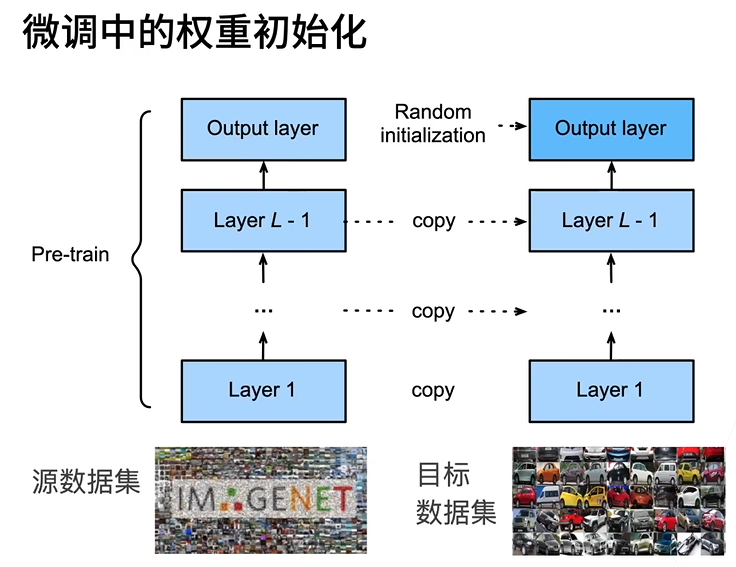

微调：就是复用特征提取部分，但是做微调，让结果更好。

训练：
- 使用更小的学习率
- 使用更少的数据迭代
- 源数据集远复杂于目标数据（数量、样本个数远大于，这样微调效果才好）

重用分类器权重：
- 源数据集包含目标数据集的部分标号
- 可以用预训练好的模型分类器中，对呀标号对应的向量来做初始化

固定一些层：
- 神经网络的学习有层次
    - 低层次特征更加通用（更抽象）
    - 高层次的特征和数据集更相关（更具体，和标号强相关）
- 可以固定底部一些层的参数，不参与更新，模型复杂度变低，更强的正则

总结：
- 微调通过使用在大数据上得到的预训练好的模型，来初始化模型权重，来完成提升精度
- 预训练模型质量很重要
- 微调通常速度更快、精度更高

代码逻辑：

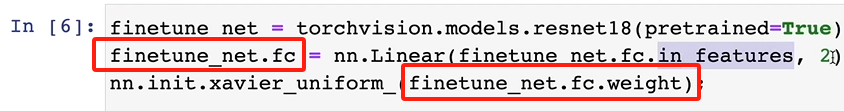


模型是下载预训练的

最后一层full connect（fc）使用线性层替换

最后一层的weight随机初始化

附加：

- 微调这部分是意味着，神经网络进行不同的目标检测，前面层的网络进行特征提取是通用的
- 数据不平衡对神经网络上层影响大
- 重用标号，对于无关的标号直接删除（把对应有用标号的权重拎出来，别的不要）。源数据集没有的标号，随机。
- 微调是迁移（transfromer learning）的一部分

查看模型的参数：

model.parameters()

查看模型参数数量，如下有1.3B

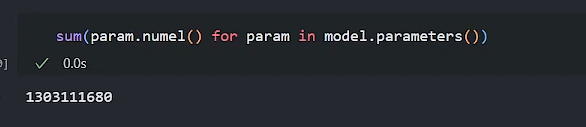

# BitFit 实战

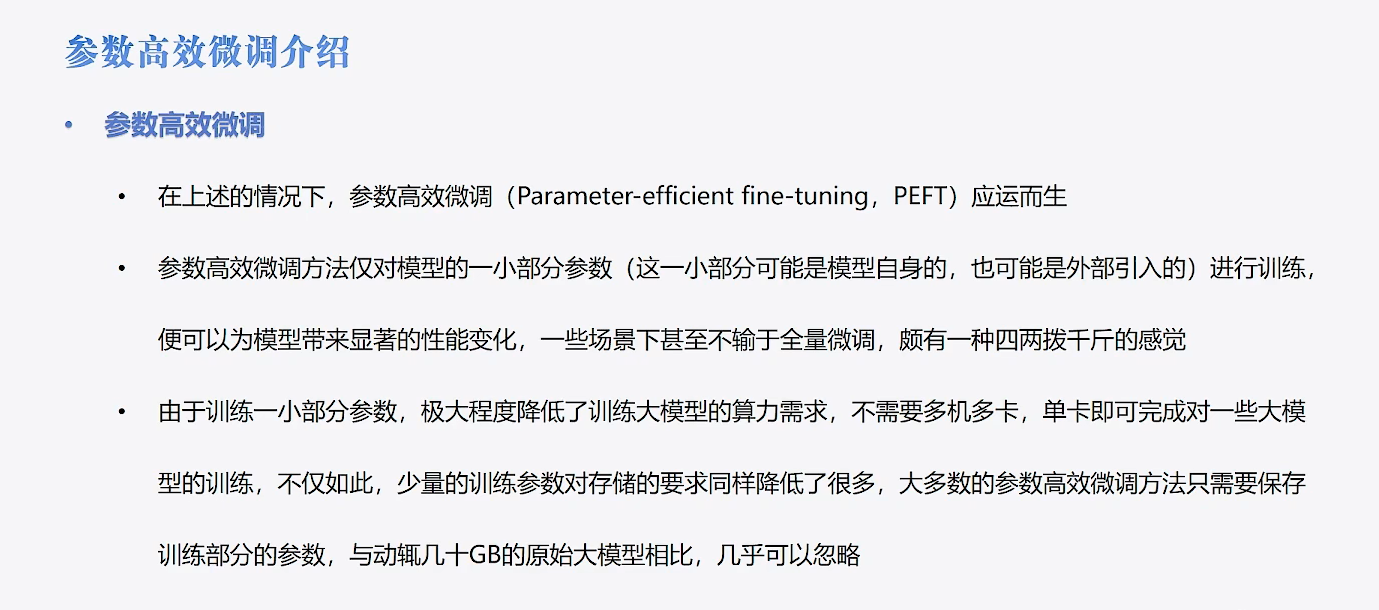

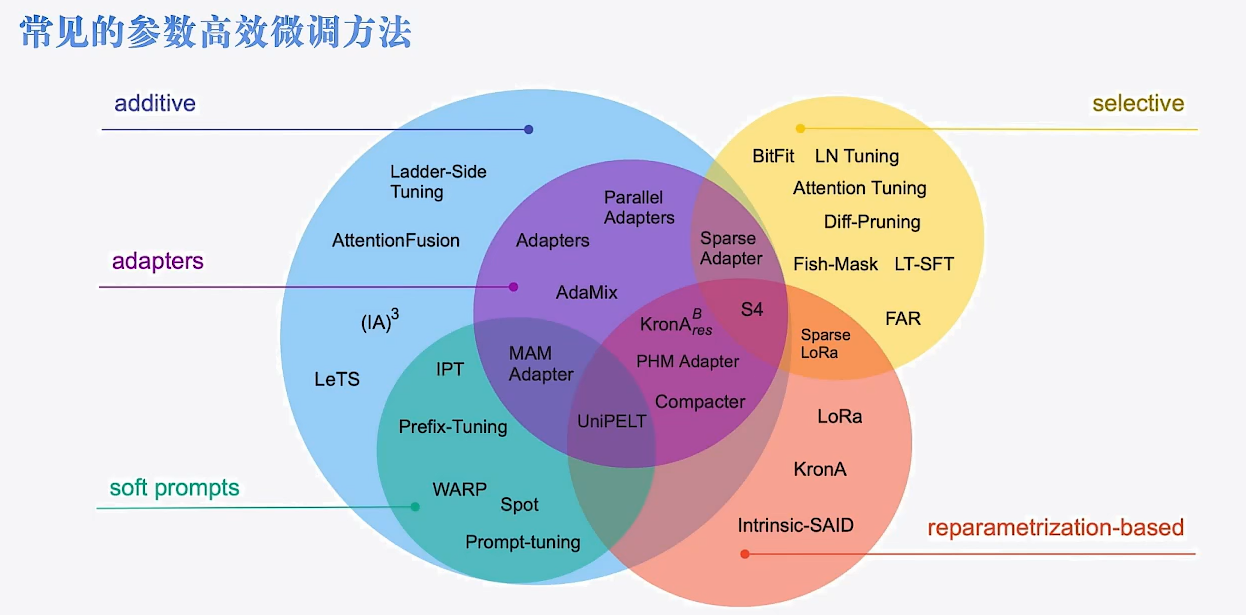

代码实战(基于Bloom模型)

- 数据集

    - https://huggingface.co/datasets/shibing624/alpaca-zh
    - 指令微调
- 预训练模型
    - Langboat/bloom-1b4-zh
- 参数高效微调方法
    - BitFit

## Step1 导入相关包

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
ds[:3]

{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
  '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'],
 'input': ['', '输入：4/16', ''],
 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}

## Step3 数据集预处理

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-389m-zh")
tokenizer

BloomTokenizerFast(name_or_path='Langboat/bloom-389m-zh', vocab_size=42437, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [6]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [ ]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

In [ ]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

## Step4 创建模型

In [7]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh", low_cpu_mem_usage=True)

In [ ]:
sum(param.numel() for param in model.parameters())

345768960

In [8]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.0099, -0.0048, -0.0111,  ..., -0.0426,  0.0099,  0.0212],
        [ 0.0048, -0.0127,  0.0138,  ..., -0.0448,  0.0003, -0.0120],
        [ 0.0065,  0.0239,  0.0050,  ..., -0.0431, -0.0067,  0.0137],
        ...,
        [ 0.0331,  0.0185,  0.0101,  ..., -0.0432, -0.0090, -0.0024],
        [-0.0132,  0.0039,  0.0054,  ..., -0.0396, -0.0120,  0.0035],
        [ 0.0044,  0.0011,  0.0230,  ..., -0.0393, -0.0087, -0.0084]],
       requires_grad=True)
Parameter containing:
tensor([0.4409, 0.3167, 0.4749,  ..., 0.0816, 0.2927, 0.6006],
       requires_grad=True)
Parameter containing:
tensor([-0.0513,  0.0164,  0.0052,  ...,  0.2412,  0.0072, -0.0292],
       requires_grad=True)
Parameter containing:
tensor([0.6621, 0.8457, 0.5884,  ..., 3.2090, 0.9180, 0.5586],
       requires_grad=True)
Parameter containing:
tensor([-0.0662, -0.0798,  0.0445,  ..., -0.1449, -0.0452,  0.0142],
       requires_grad=True)
Parameter containing:
tensor([[-2.7695e-02,  1.8280e-02, 

In [ ]:
model.parameters

<bound method Module.parameters of BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(42437, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05

model size: 1.3B

model: 1.3G * 4 ~= 5.2G

gradient: 1.3G * 4 ~= 5.2G

optimizer: 1.3G * 4 * 2 ~= 10.4G

sum: 20.8G

## BitFit

In [8]:
# bitfit
# 参数微调核心：冻结模型
# 选择模型参数里面的所有bias部分，全连接部分，WX+B，B就是bias部分

num_param = 0
for name, param in model.named_parameters():
    if "bias" not in name:
        param.requires_grad = False
    else:
        num_param += param.numel()

num_param

272384

- 微调的参数只是预训练模型参数的0.0007：

In [20]:
num_param / sum(param.numel() for param in model.parameters())

0.0007877630195608073

## Step5 配置训练参数

In [9]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

## Step6 创建训练器

In [10]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Step7 模型训练

In [11]:
trainer.train()

Step,Training Loss
10,3.315200
20,3.399200
30,3.216600
40,3.123500
50,3.159400
60,3.148600
70,2.942100
80,2.942700
90,2.938200
100,2.853500


TrainOutput(global_step=3357, training_loss=2.768904874322668, metrics={'train_runtime': 1300.4943, 'train_samples_per_second': 20.652, 'train_steps_per_second': 2.581, 'total_flos': 3700748600918016.0, 'train_loss': 2.768904874322668, 'epoch': 1.0})

In [12]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True)

'Human: 考试有哪些技巧？\n\nAssistant: 首先，考生首先对考试内容及难度有足够了解，以便制定合理并有效的复习计划。其次，考生应对考试进行有效的准备，包括制定有效的复习方案。考生应根据考试的不同阶段和要求设置相应的计划，并且确保该计划的执行。考生还应提前做好准备，如准备好考试期间的学习用具，如个人电脑，学习方法，笔记，练习等。最后，考生还应及时将复习方案更新至最新的考试信息，以便考生能够从容应对考试。\n'

## Step8 模型推理

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)

In [ ]:
ipt = "Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: "
pipe(ipt, max_length=256, do_sample=True, )